### **1. Open Dataset**

In [24]:
import xarray as xr

ds = xr.open_dataset('dataset_precip.nc')
print(ds)

<xarray.Dataset> Size: 15kB
Dimensions:  (time: 730)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2022-01-01T12:00:00 ... 2023-12-31T12:...
Data variables:
    tcwv     (time) float32 3kB ...
    tcc      (time) float32 3kB ...
    tp       (time) float32 3kB ...
Attributes:
    description:    Merged ERA5 and MODIS AOD dataset
    creation_date:  2024-12-29
    time_zone:      UTC
    region:         51E-52E, 35N-36N



### **2. Handle Missing Data (if any)**
Check if there are any missing values and handle them appropriately.


In [25]:
import pandas as pd

df = ds.to_dataframe().reset_index()

# print(df.isnull().sum())

df = df.dropna()

#rescale TP to mm/day
df[['tp']] = df[['tp']] * 1000

df.head()

,time,tcwv,tcc,tp
0,2022-01-01 12:00:00,7.131459,0.919266,0.000057
1,2022-01-02 12:00:00,9.397189,1.000000,0.000362
2,2022-01-03 12:00:00,8.124803,0.978844,0.033684
3,2022-01-04 12:00:00,6.060751,0.000000,0.000000
4,2022-01-05 12:00:00,6.495852,0.602828,0.054436


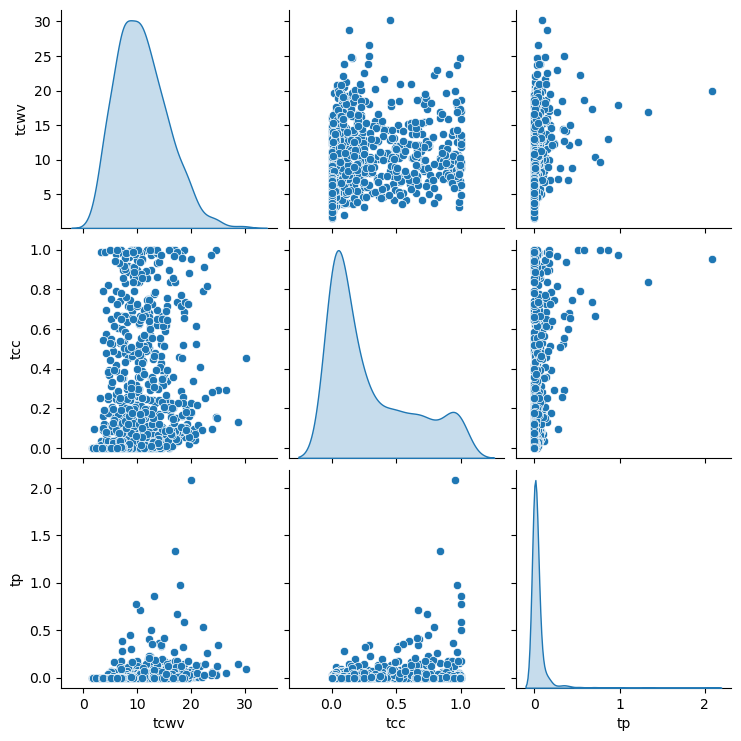

In [26]:
import seaborn as sns

sns.pairplot(df, diag_kind='kde')

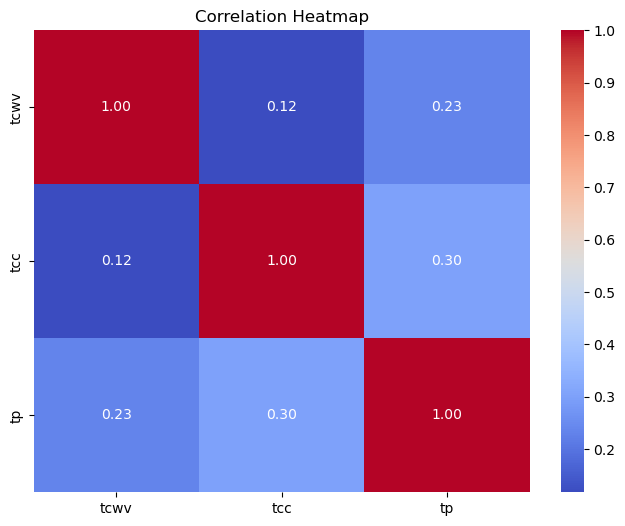

In [27]:
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(8, 6))
corr = df[['tcwv', 'tcc', 'tp']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


### **3. Train-Test Split for Modeling**
Use the DataFrame for machine learning.


In [28]:
#train test split the dataset
from sklearn.model_selection import train_test_split


X = df[['tcwv', 'tcc']]
y = df[['tp']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)


print(X_train.shape)
print(X_test.shape)

(584, 2)
(146, 2)


### **4. Train a Decision Tree Regressor**
Train the regressor using the data.


In [29]:
#train a Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

#setup the model
DTR = DecisionTreeRegressor(max_depth=5, random_state=42)

DTR.fit(X_train, y_train)


y_predict = DTR.predict(X_test)

mse = mean_squared_error(y_predict, y_test)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.06816359397164122


### **Predict for a New Day**
Use the trained model to predict precipitation for new conditions.


In [30]:
# Example: Predict for tcwv=20.0, tcc=0.7
sample_prediction = DTR.predict([[13.0, 0.7]])
print(f"Predicted precipitation for tcwv=20.0, tcc=0.7: {sample_prediction[0]:.2f} mm")


Predicted precipitation for tcwv=20.0, tcc=0.7: 0.10 mm


/Users/admin/miniforge3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(



### **5. Interpret the Tree**
Interpret the tree to understand how it makes predictions.

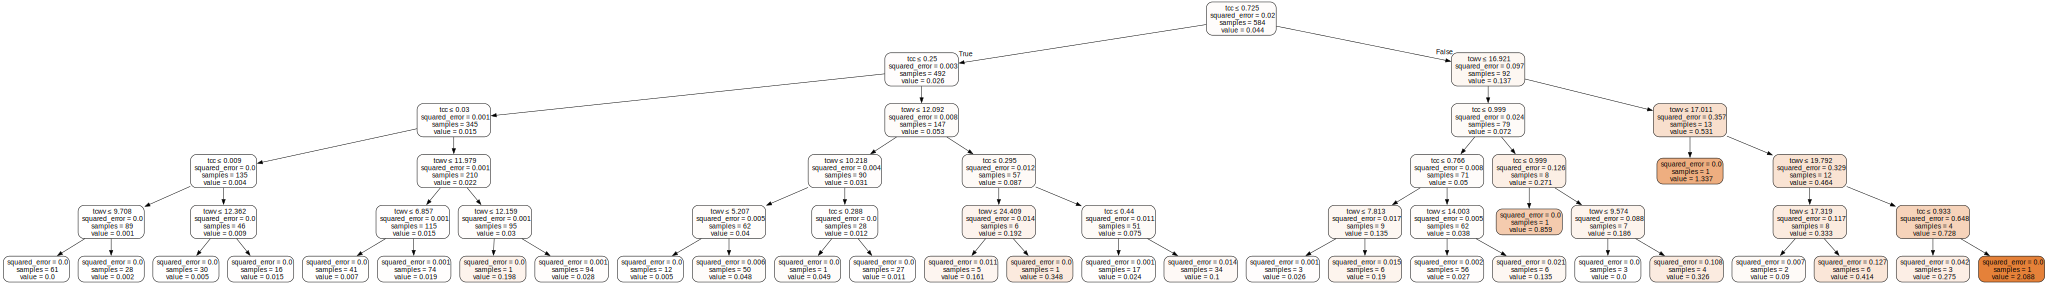

In [31]:
# Install graphviz if not already installed
# !pip install graphviz

from sklearn import tree
import graphviz

# Export the decision tree to a DOT format
dot_data = tree.export_graphviz(
    DTR,
    out_file=None,
    feature_names=['tcwv', 'tcc'],
    filled=True,
    rounded=True,
    special_characters=True
)

# Use graphviz to render the tree
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Saves the tree as a PDF file
graph


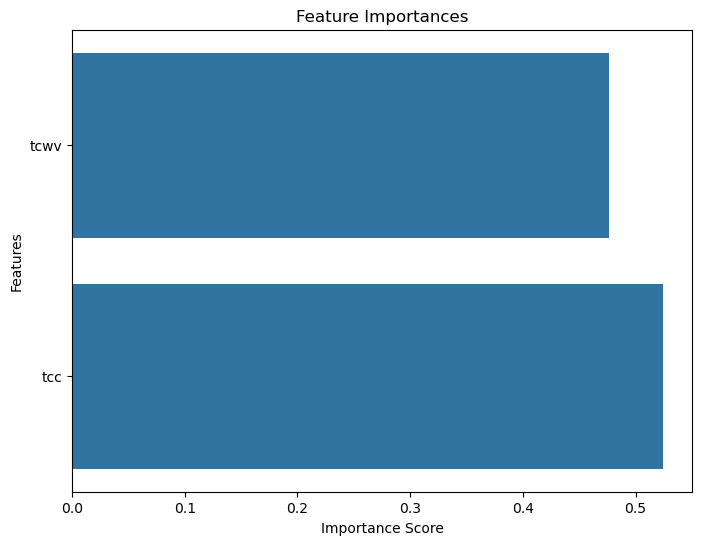

In [32]:
# Feature Importance
importances = DTR.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feat_importances = pd.Series(importances, index=feature_names)

# Plot Feature Importances
plt.figure(figsize=(8, 6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


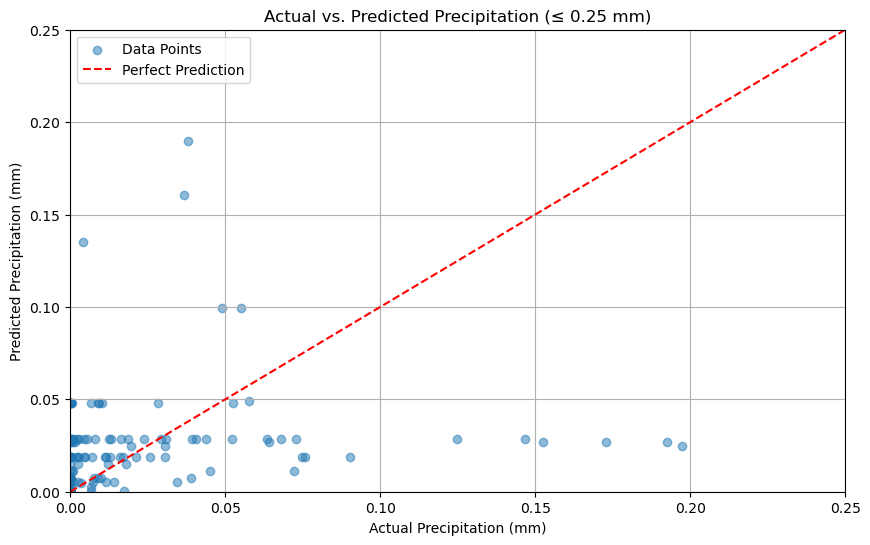

In [33]:
# Predictions vs Actual (Limited to x and y ≤ 0.25 mm)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict, alpha=0.5, label='Data Points')
plt.plot([0, 0.25], [0, 0.25], 'r--', label='Perfect Prediction')  # Diagonal line

# Set axis limits to 0.25 mm
plt.xlim(0, 0.25)
plt.ylim(0, 0.25)

plt.xlabel('Actual Precipitation (mm)')
plt.ylabel('Predicted Precipitation (mm)')
plt.title('Actual vs. Predicted Precipitation (≤ 0.25 mm)')
plt.legend()
plt.grid(True)
plt.show()



## Lag Features?

- **Temporal Dependency**: Today’s precipitation might depend on how water vapor or cloud cover evolved in the days leading up to today.  
- **Improved Predictive Power**: Adding lags often improves accuracy because weather processes have memory (e.g., if it was very humid yesterday, it might still be humid today).


In [34]:
# Create 1-day lag features
df['tcwv_lag1'] = df['tcwv'].shift(1)
df['tcc_lag1']  = df['tcc'].shift(1)
df['tp_lag1']   = df['tp'].shift(1)

# Create 2-day lag features
df['tcwv_lag2'] = df['tcwv'].shift(2)
df['tcc_lag2']  = df['tcc'].shift(2)
df['tp_lag2']   = df['tp'].shift(2)


In [35]:
df = df.dropna(subset=['tcwv_lag1', 'tcc_lag1', 'tp_lag1', 
                       'tcwv_lag2', 'tcc_lag2', 'tp_lag2'])


In [36]:
# Sort by time just to be safe
df = df.sort_values('time').reset_index(drop=True)

# Choose a cutoff date for training vs. testing
cutoff_date = '2023-07-01'
df_train_2 = df[df['time'] < cutoff_date].copy()
df_test_2  = df[df['time'] >= cutoff_date].copy()

# Define features (X) and target (y)
FEATURES_2 = [
    'tcwv', 'tcc', 
    'tp_lag1', 'tcwv_lag1', 'tcc_lag1',
    'tp_lag2', 'tcwv_lag2', 'tcc_lag2'
]
X_train_2 = df_train_2[FEATURES_2]
y_train_2 = df_train_2['tp']  # Predict today's precipitation

X_test_2 = df_test_2[FEATURES_2]
y_test_2 = df_test_2['tp']


print(X_train_2.shape)
print(X_test_2.shape)


(544, 8)
(184, 8)


In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model (tune max_depth, min_samples_leaf, etc. as needed)
DTR_2 = DecisionTreeRegressor(max_depth=5, random_state=42)

# Fit on the training set
DTR_2.fit(X_train_2, y_train_2)

# Predict on the test set
y_pred_2 = DTR_2.predict(X_test_2)

# Evaluate performance
mse = mean_squared_error(y_test_2, y_pred_2)
print("Mean Squared Error with lag features:", mse)


Mean Squared Error with lag features: 0.007854040315639157


In [38]:
# Input values for prediction
new_data = {
    'tcwv':       [17.0],  
    'tcc':        [0.7],   
    'tp_lag1':    [0.0],    
    'tcwv_lag1':  [18.2],   
    'tcc_lag1':   [1.0],   
    'tp_lag2':    [0.0],   
    'tcwv_lag2':  [25.0],   
    'tcc_lag2':   [0.95]
}
# Create a DataFrame
new_input = pd.DataFrame(new_data)


print(new_input)


   tcwv  tcc  tp_lag1  tcwv_lag1  tcc_lag1  tp_lag2  tcwv_lag2  tcc_lag2
0  17.0  0.7      0.0       18.2       1.0      0.0       25.0      0.95


In [39]:

# Predict using the trained model
predicted_tp_2 = DTR_2.predict(new_input)
print(f"Predicted precipitation: {predicted_tp_2[0]:.2f} mm")

Predicted precipitation: 2.09 mm


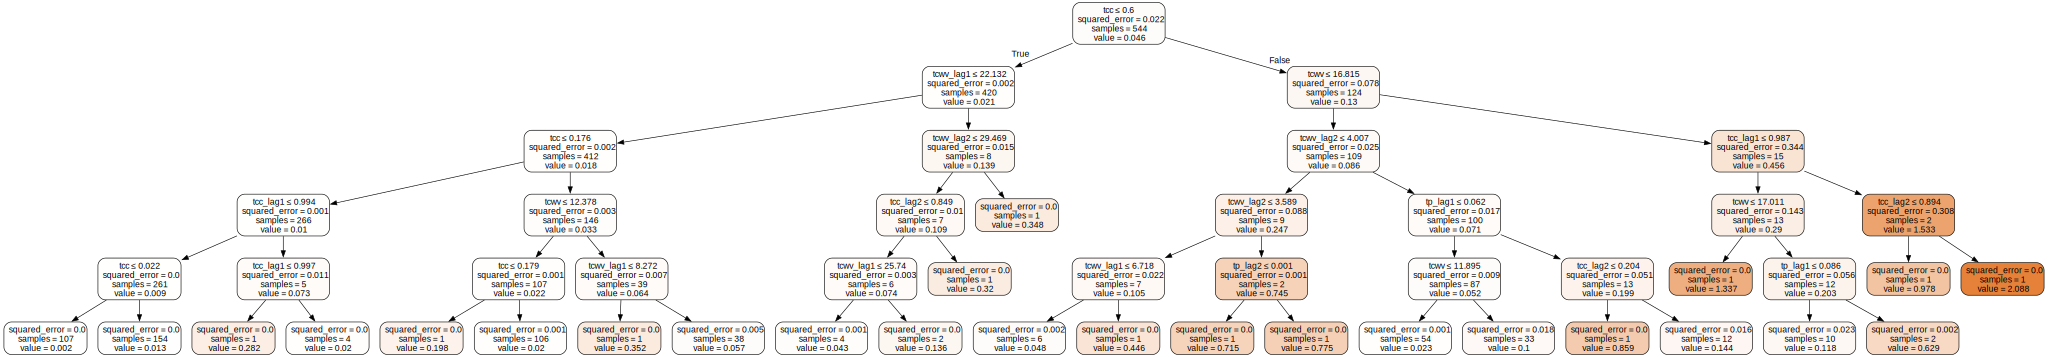

In [40]:
# Install graphviz if not already installed
# !pip install graphviz

from sklearn import tree
import graphviz

# Export the decision tree to a DOT format
dot_data = tree.export_graphviz(
    DTR_2,
    out_file=None,
    feature_names=FEATURES_2,
    filled=True,
    rounded=True,
    special_characters=True
)

# Use graphviz to render the tree
graph = graphviz.Source(dot_data)
graph.render("decision_tree_2")  # Saves the tree as a PDF file
graph


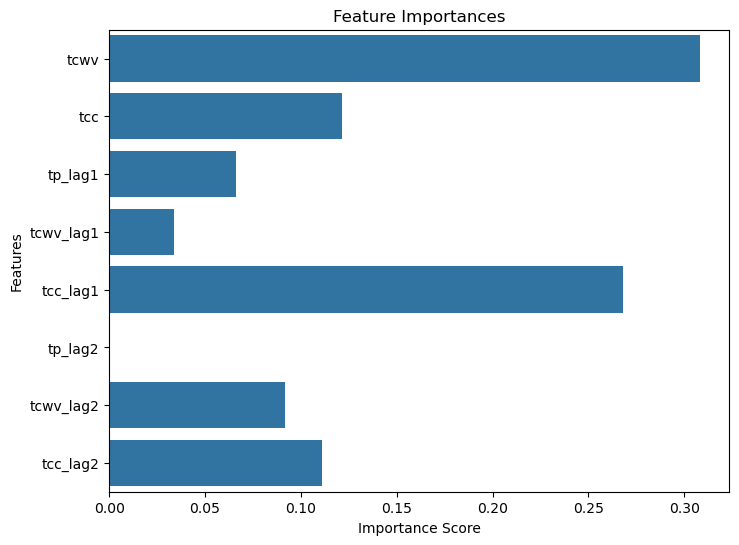

In [41]:
# Feature Importance
importances = DTR_2.feature_importances_

# Create a DataFrame for visualization
feat_importances = pd.Series(importances, index=FEATURES_2)

# Plot Feature Importances
plt.figure(figsize=(8, 6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


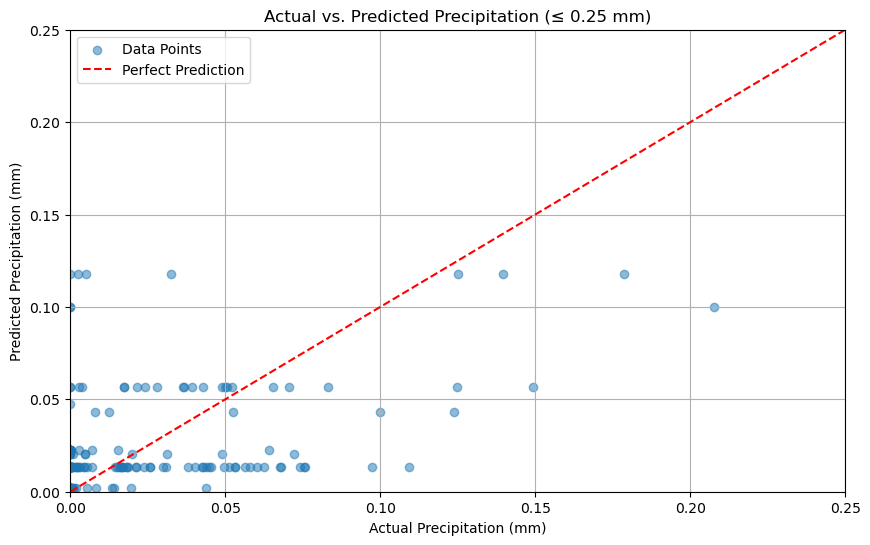

In [42]:
# Predictions vs Actual (Limited to x and y ≤ 0.25 mm)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_2, y_pred_2, alpha=0.5, label='Data Points')
plt.plot([0, 0.5], [0, 0.5], 'r--', label='Perfect Prediction')  # Diagonal line

# Set axis limits to 0.25 mm
plt.xlim(0, 0.25)
plt.ylim(0, 0.25)

plt.xlabel('Actual Precipitation (mm)')
plt.ylabel('Predicted Precipitation (mm)')
plt.title('Actual vs. Predicted Precipitation (≤ 0.25 mm)')
plt.legend()
plt.grid(True)
plt.show()
